# ENSO_lifecycle: temporal evolution of SST anomalies in the central equatorial Pacific

Computes the temporal root mean square error (RMSE) of sea surface temperature anomalies (SSTA) in the Niño3.4 region (horizontal average over 5°S–5°N, 170°W–120°W) between model and observations. The analysis spans 6 years centred on ENSO peak years to evaluate the ability of the model to capture the full lifecycle of ENSO events, including onset, peak, and decay phases.


*reference*
https://github.com/CLIVAR-PRP/ENSO_metrics/wiki/EnsoSstTsRmse

### map sst bias
https://github.com/CLIVAR-PRP/ENSO_metrics/wiki/BiasSstLonRmse


### Dask Cluster 

Start a cluster with multiple cores 

In [ ]:
from dask.distributed import Client, progress
client = Client()
client

## Datasets

In [1]:
from esmvalcore.dataset import Dataset

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.8/lib/python3.11/site-packages/esmvalcore/config/_config_object.py:639: ESMValCoreDeprecationWarning: Usage of the single configuration file ~/.esmvaltool/config-user.yml or specifying it via CLI argument `--config_file` has been deprecated in ESMValCore version 2.12.0 and is scheduled for removal in version 2.14.0. Please run `mkdir -p ~/.config/esmvaltool && mv /home/189/fc6164/.esmvaltool/config-user.yml ~/.config/esmvaltool` (or alternatively use a custom `--config_dir`) and omit `--config_file`.
  config_obj.reload()
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.8/lib/python3.11/site-packages/esmvalcore/config/_config_validators.py:405: ESMValCoreDeprecationWarning: The configuration option or command line argument `config_file` has been deprecated in ESMValCore version 2.12.0 and is scheduled for removal in version 2.14.0. Please use the option `config_dir` instead.
  _handle_deprecation(option, deprecated_version, remov

In [2]:
model_datasets = {
"ACCESS-ESM1-5": 
    Dataset(
    short_name='ts',
    project='CMIP6',
    mip="Amon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="18500101/20190101",
    dataset="ACCESS-ESM1-5",
    grid="gn"
),
"ACCESS-CM2": 
    Dataset(
    short_name='ts',
    project='CMIP6',
    mip="Amon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="18500101/20190101",
    dataset="ACCESS-CM2",
    grid="gn"
),
}

obs_datasets = {
"HadISST": 
    Dataset(
    short_name='ts',
    dataset='HadISST',
    mip="Amon",
    project='OBS',
    type='reanaly',
    tier=2)
}

## Add Ancillary files

In [3]:
for name, dataset in model_datasets.items():
    dataset.add_supplementary(short_name='sftlf', mip="fx")
    dataset.add_supplementary(short_name="areacella", mip="fx")

In [4]:
model_datasets = {name: dataset.load() for name, dataset in model_datasets.items()}
obs_datasets = {name: dataset.load() for name, dataset in obs_datasets.items()}

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.8/lib/python3.11/site-packages/esmvalcore/config/_config_validators.py:405: ESMValCoreDeprecationWarning: The configuration option or command line argument `config_file` has been deprecated in ESMValCore version 2.12.0 and is scheduled for removal in version 2.14.0. Please use the option `config_dir` instead.
  _handle_deprecation(option, deprecated_version, remove_version, more_info)
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.8/lib/python3.11/site-packages/esmvalcore/config/_config_validators.py:405: ESMValCoreDeprecationWarning: The configuration option or command line argument `config_file` has been deprecated in ESMValCore version 2.12.0 and is scheduled for removal in version 2.14.0. Please use the option `config_dir` instead.
  _handle_deprecation(option, deprecated_version, remove_version, more_info)
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.8/lib/python3.11/site-packages/esmvalcore/config/_config_validato

### Preprocessor functions:
https://docs.esmvaltool.org/projects/ESMValCore/en/latest/recipe/preprocessor.html


In [5]:
from esmvalcore.preprocessor import anomalies
from esmvalcore.preprocessor import area_statistics
from esmvalcore.preprocessor import rolling_window_statistics
from esmvalcore.preprocessor import climate_statistics
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import extract_time
from esmvalcore.preprocessor import extract_month
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import mask_landsea
import iris

import matplotlib.pyplot as plt
import iris.quickplot as qplt
import numpy as np


## Map SST bias 

In [6]:
def prepoc2(cube):
    # preprocesser steps for each dataset 
    nino3_latext_region = {"start_longitude": 140., "end_longitude": 270., "start_latitude": -15., "end_latitude": 15.}
    cube = extract_time(cube, start_year=1900, start_month=1, start_day=1, end_year=2014, end_month=12, end_day=31)
    cube = convert_units(cube, units="degC")
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = mask_landsea(cube, mask_out="land")
    cube = climate_statistics(cube, operator="mean", period="full")
    cube = extract_region(cube, **nino3_latext_region)
    return cube

model_datasets_prep2 = {name: prepoc2(dataset) for name, dataset in model_datasets.items()}
obs_datasets_prep2 = {name: prepoc2(dataset) for name, dataset in obs_datasets.items()}

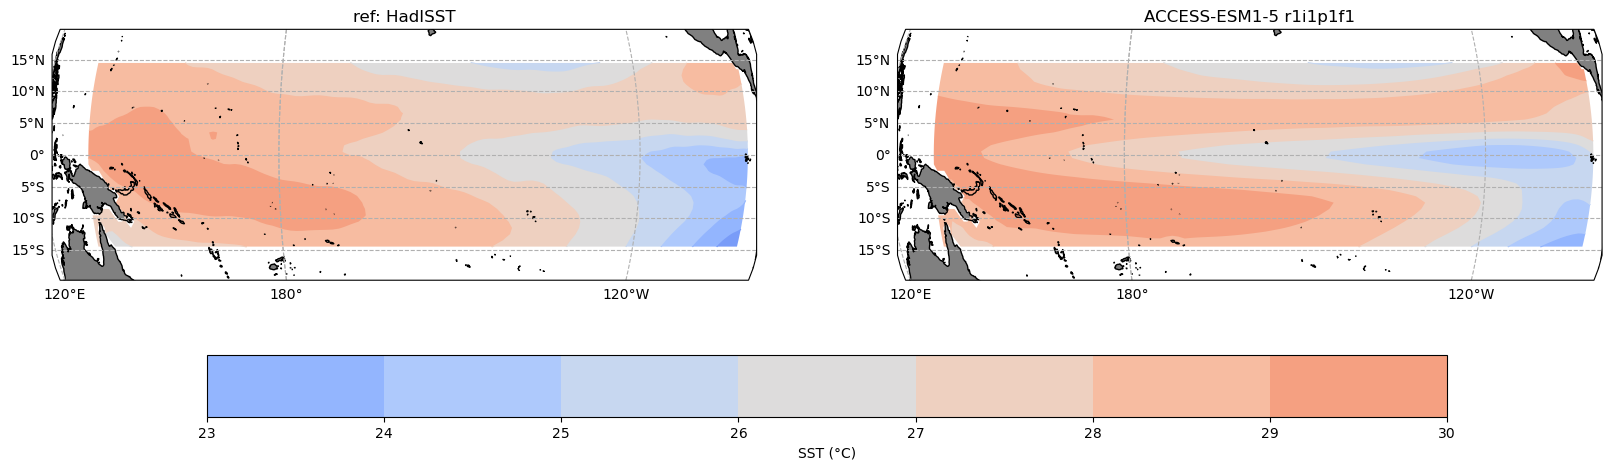

In [7]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import iris.plot as iplt

obs_data = obs_datasets_prep2["HadISST"]
model_data = model_datasets_prep2["ACCESS-ESM1-5"]

# Use the coolwarm colormap
cmap = plt.get_cmap('coolwarm')

# Create a large figure
fig = plt.figure(figsize=(20, 10))

# Center the map on the Pacific Ocean (roughly around 180° longitude)
proj = ccrs.Orthographic(central_longitude=-160, central_latitude=0)

# Define the normalization for the color scale with range of 20 to 33°C
norm = mcolors.Normalize(vmin=20, vmax=33)

# Plot #1: contourf with axes longitude from -180 to 180
ax1 = plt.subplot(121, projection=proj)
cf1 = iplt.contourf(obs_data, cmap=cmap, norm=norm)
ax1.add_feature(cfeature.LAND, facecolor='gray')  # Add land feature with gray color
ax1.coastlines()
ax1.set_extent([120, -80, -20, 20], crs=ccrs.PlateCarree())
ax1.set_title("ref: HadISST")

# Add gridlines for latitude and longitude
gl1 = ax1.gridlines(draw_labels=True, linestyle='--')
gl1.top_labels = False
gl1.right_labels = False

# Plot #2: contourf with axes longitude from 0 to 360
ax2 = plt.subplot(122, projection=proj)
cf2 = iplt.contourf(model_data, cmap=cmap, norm=norm)
ax2.add_feature(cfeature.LAND, facecolor='gray')  # Add land feature with gray color
ax2.coastlines()
ax2.set_extent([120, -80, -20, 20], crs=ccrs.PlateCarree())
ax2.set_title("ACCESS-ESM1-5 r1i1p1f1")

# Add gridlines for latitude and longitude
gl2 = ax2.gridlines(draw_labels=True, linestyle='--')
gl2.top_labels = False
gl2.right_labels = False

# Add a single colorbar at the bottom
cbar = fig.colorbar(cf2, ax=[ax1, ax2], orientation='horizontal', pad=0.15, shrink=0.8)
cbar.set_label('SST (°C)')

plt.subplots_adjust(bottom=0.3)  # Further adjust bottom margin to fit the colorbar
plt.show()


## ENSO lifecycle

In [8]:
def sst_enso_n34(cube):
    nino34_latext_region = {"start_longitude": 190., "end_longitude": 240., "start_latitude": -5., "end_latitude": 5.}
    cube = extract_time(cube, start_year=1900, start_month=1, start_day=1, end_year=2014, end_month=12, end_day=31)    
    cube = convert_units(cube, units="degC")
    cube = mask_landsea(cube, mask_out="land") #shp or land fraction
    cube = extract_region(cube, **nino34_latext_region)

    cube = anomalies(cube, period='monthly') 
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    cube = area_statistics(cube,operator='mean')

    return cube


In [9]:
model_datasets_prep1 = {name: sst_enso_n34(dataset) for name, dataset in model_datasets.items()}

obs_datasets_prep1 = {name: sst_enso_n34(dataset) for name, dataset in obs_datasets.items()}


/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.8/lib/python3.11/site-packages/iris/cube.py:4896: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.8/lib/python3.11/site-packages/iris/cube.py:4896: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.8/lib/python3.11/site-packages/iris/cube.py:4896: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.8/lib/python3.11/site-packages/iris/cube.py:4896: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.8/lib/python3.11/site-packages/iris/cube.py:489

## Diagnostic Level 1

The first level shows the diagnostic used to compute the metric and highlight the main differences between the model and the reference.

In [10]:

def sst_regressed(n34_cube): 
    """Regression function for sst_time_series on sst_enso 6 year epoch."""
    n34_dec = extract_month(n34_cube, 12)
    leadlagyr = 3
    n34_dec_years = [n34_dec.coord('time').units.num2date(time).year
                     for time in n34_dec.coord('time').points]
    event_years = n34_dec_years[leadlagyr:-leadlagyr]
    # Ensure that the selected years are not the last years
    years_of_interest = []
    for yr in event_years:
        years_of_interest.append([yr - 2, yr - 1, yr, yr + 1, yr + 2, yr + 3])

    n34_selected = []
    print(len(years_of_interest))
    # n34_area_selected = []
    for enso_epoch in years_of_interest:
        # Select the data for the current year and append it to n34_selected
        year_enso = iris.Constraint(time=lambda cell: cell.point.year in enso_epoch)
        cube_2 = n34_cube.extract(year_enso)
        n34_selected.append(cube_2.core_data()) 
        
    event_constr = iris.Constraint(time=lambda cell: cell.point.year in event_years)
    n34_dec_ct = n34_dec.extract(event_constr)
    
    # 1) linear regression of sst_time_series on sst_enso
    a_data = np.array(n34_selected)
    b_data = n34_dec_ct.data
    b_with_intercept = np.vstack([b_data, np.ones_like(b_data)]).T
    print(a_data.shape, b_with_intercept.shape)
    coefs, _, _, _ = np.linalg.lstsq(b_with_intercept, a_data, rcond=None)
    
    return coefs[0]

In [11]:
model_n34 = model_datasets_prep1["ACCESS-CM2"]

obs_n34 = obs_datasets_prep1["HadISST"]

In [12]:

model = sst_regressed(model_n34)

obs = sst_regressed(obs_n34)

rmse = np.sqrt(np.mean((obs - model) ** 2))
rmse

108
(108, 72) (108, 2)
108
(108, 72) (108, 2)


np.float32(0.23681001)

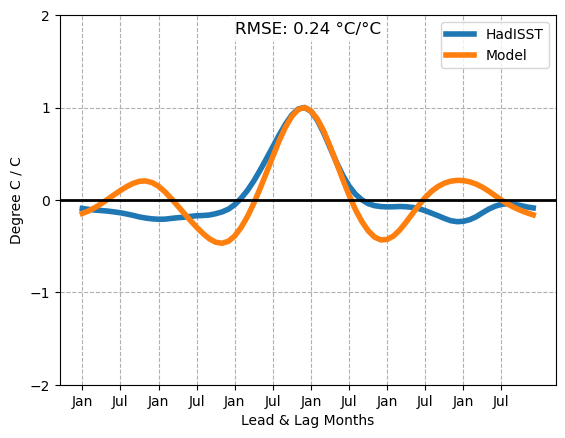

In [13]:
months = np.arange(1, 73) - 36

# Plot the slope
plt.plot(months, obs, label='HadISST', lw=4)
plt.plot(months, model, label='Model', lw=4)

# Draw a thicker line at y=0
plt.axhline(y=0, color='black', linewidth=2) #, label='Zero Line')

# Define custom ticks for the x-axis (every 6 months)
xticks = np.arange(1, 73, 6) - 36  # Adjust for lead/lag months
xtick_labels = ['Jan', 'Jul'] * (len(xticks) // 2)

# Set the labels and titles
plt.xlabel('Lead & Lag Months')
plt.ylabel('Degree C / C')
plt.legend()
plt.grid(linestyle='--')

# Apply the custom ticks and labels to the x-axis
plt.xticks(xticks, xtick_labels)
plt.yticks(np.arange(-2,2.5, step=1))

# Adding RMSE text on top of the plot
plt.text(0.5, 0.95, f'RMSE: {rmse:.2f} °C/°C', fontsize=12, ha='center', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
# Show the plot
plt.show()

Figure 1: Temporal evolution of sea surface temperature anomalies (SSTA) in the central equatorial Pacific (Niño 3.4 region average), illustrating the ENSO-associated variability. The model tends to exhibit overly frequent transitions between negative and positive SSTA phases. The black curve represents the reference data, while the blue curve corresponds to the model output. The derived metric is the temporal root mean square error (RMSE) between the model and reference curves.

In [14]:
## add another model
model_esm_n34 = model_datasets_prep1["ACCESS-ESM1-5"]
model_esm = sst_regressed(model_esm_n34)

108
(108, 72) (108, 2)


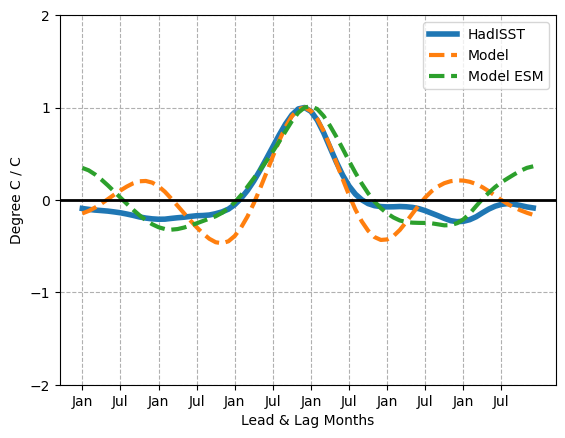

In [15]:
months = np.arange(1, 73) - 36

# Plot the slope
plt.plot(months, obs, label='HadISST', lw=4)
plt.plot(months, model, label='Model', lw=3, linestyle='dashed')
plt.plot(months, model_esm, label='Model ESM', lw=3, linestyle='dashed')


# Draw a thicker line at y=0
plt.axhline(y=0, color='black', linewidth=2) #, label='Zero Line')

# Define custom ticks for the x-axis (every 6 months)
xticks = np.arange(1, 73, 6) - 36  # Adjust for lead/lag months
xtick_labels = ['Jan', 'Jul'] * (len(xticks) // 2)

# Set the labels and titles
plt.xlabel('Lead & Lag Months')
plt.ylabel('Degree C / C')
plt.legend()
plt.grid(linestyle='--')

# Apply the custom ticks and labels to the x-axis
plt.xticks(xticks, xtick_labels)
plt.yticks(np.arange(-2,2.5, step=1))

# Show the plot
plt.show()